In [1]:
import pandas as pd

In [2]:
load_dataset = pd.read_excel("Expanded_ST_R_With_GAN.xlsx")

In [3]:
load_dataset.head()

,Tablet per box,Early stock,Purchasing,Usage (years),Usage (months),Usage (days),Purchasing base price,Safety Stock,Left Stock,Total of Stagnant Drugs,...,Unit_Botol,Unit_Pen,Unit_Strip,Unit_Tablet,Unit_Vial,Category_Expired,Drug_Name_Label,expired_month,expired_year,synthetic
0,0.292929,0.011429,0.013846,0.003486,0.003486,0.003486,0.006679,0.003486,0.032080,0.031738,...,0,0,0,1,0,1,0,8,2017,0
1,1.000000,0.000000,0.250000,0.191970,0.191970,0.191970,0.001030,0.191970,0.268027,0.171383,...,0,0,0,1,0,0,1,9,2016,0
2,0.292929,0.000000,0.048462,0.044799,0.044799,0.044799,0.004818,0.044799,0.034701,0.011472,...,0,0,0,1,0,0,2,5,2017,0
3,0.000000,0.001429,0.000692,0.000498,0.000498,0.000498,1.000000,0.000498,0.000000,0.000158,...,1,0,0,0,0,0,3,11,2017,0
4,0.040404,0.008413,0.007692,0.007206,0.007206,0.007206,0.017683,0.007206,0.006521,0.003183,...,0,0,0,0,0,0,4,5,2016,0


In [4]:
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

In [5]:
load_dataset_risk_augmented = load_dataset

In [6]:
num_risk_samples = 100
safe_samples = load_dataset_risk_augmented[
    load_dataset_risk_augmented['Left Stock'] >= load_dataset_risk_augmented['Safety Stock']
]

if len(safe_samples) < num_risk_samples:
    synthetic_base = resample(safe_samples, n_samples=num_risk_samples, replace=True, random_state=42)
else:
    synthetic_base = safe_samples.sample(n=num_risk_samples, random_state=42)

In [7]:
synthetic_risk_samples = synthetic_base.copy()
synthetic_risk_samples['Left Stock'] = synthetic_risk_samples['Safety Stock'] * 0.5
synthetic_risk_samples['Stock_Risk_Flag'] = 1

In [8]:
load_dataset_risk_augmented = pd.concat([load_dataset_risk_augmented, synthetic_risk_samples], ignore_index=True)

print("Updated class distribution:")
print(load_dataset_risk_augmented['Stock_Risk_Flag'].value_counts())

Updated class distribution:
Stock_Risk_Flag
0    297
1    100
Name: count, dtype: int64


In [9]:
load_dataset_risk_augmented.dropna(subset=['Left Stock', 'Safety Stock', 'Purchasing', 'Usage (months)'], inplace=True)
X = load_dataset_risk_augmented[['Left Stock', 'Safety Stock', 'Purchasing', 'Usage (months)']]
y = load_dataset_risk_augmented['Stock_Risk_Flag']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [12]:
y_pred = gb_classifier.predict(X_test)

In [134]:
X_test_used = X_test[['Left Stock', 'Safety Stock', 'Purchasing', 'Usage (months)']]

stockout_df = X_test.copy()
stockout_df["Predicted"] = gb_classifier.predict(X_test_used)
stockout_df["Probability"] = gb_classifier.predict_proba(X_test_used)[:, 1]
stockout_df["Stock-Out Risk"] = stockout_df["Predicted"].map({1: "Yes", 0: "No"})
stockout_df["Actual"] = y_test.values

stockout_df.to_csv("stockout_predictions.csv", index=False)

print("\n✅ Stock-out predictions saved to 'stockout_predictions.csv'")


✅ Stock-out predictions saved to 'stockout_predictions.csv'


In [136]:
features = ['Left Stock', 'Safety Stock', 'Purchasing', 'Usage (months)']
X_full = load_dataset_risk_augmented[features]

load_dataset_risk_augmented["Predicted"] = gb_classifier.predict(X_full)
load_dataset_risk_augmented["Probability"] = gb_classifier.predict_proba(X_full)[:, 1]
load_dataset_risk_augmented["Stock-Out Risk"] = load_dataset_risk_augmented["Predicted"].map({1: "Yes", 0: "No"})

load_dataset_risk_augmented.to_csv("stockout_predictions_full.csv", index=False)
print("✅ Full stock-out prediction file saved.")

✅ Full stock-out prediction file saved.


In [13]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\n📊 Gradient Boosting Model Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


📊 Gradient Boosting Model Performance:
Accuracy: 0.82
Precision: 0.82
Recall: 0.82
Confusion Matrix:
[[56  3]
 [11 10]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        59
           1       0.77      0.48      0.59        21

    accuracy                           0.82        80
   macro avg       0.80      0.71      0.74        80
weighted avg       0.82      0.82      0.81        80



In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [15]:
X = load_dataset_risk_augmented.drop(columns=['Stock_Risk_Flag']).select_dtypes(include='number')
y = load_dataset_risk_augmented['Stock_Risk_Flag']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred = gb.predict(X_test_scaled)

D:\Downloads\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


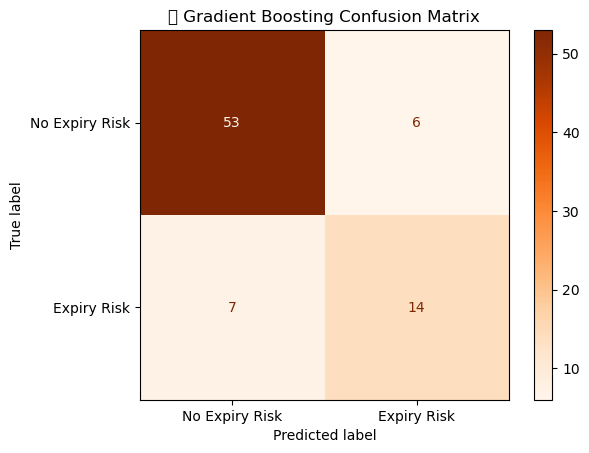

In [18]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Expiry Risk', 'Expiry Risk'])
disp.plot(cmap='Oranges')
plt.title("🔥 Gradient Boosting Confusion Matrix")
plt.show()

In [50]:
from sklearn.metrics import roc_curve, auc

In [66]:
gb = GradientBoostingClassifier()
gb.fit(X_train_scaled, y_train)

GradientBoostingClassifier()

In [67]:
y_proba = gb.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

C:\Users\User\AppData\Local\Temp\ipykernel_51340\415279406.py:9: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\Downloads\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


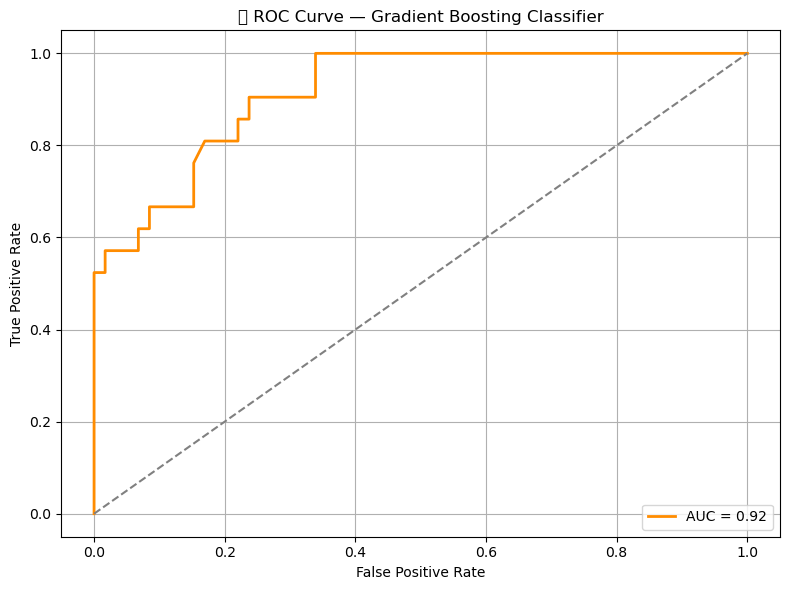

In [58]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 ROC Curve — Gradient Boosting Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
from sklearn.metrics import precision_recall_curve

In [68]:
gb = GradientBoostingClassifier()
gb.fit(X_train_scaled, y_train)

GradientBoostingClassifier()

In [69]:
y_proba = gb.predict_proba(X_test_scaled)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba)

C:\Users\User\AppData\Local\Temp\ipykernel_51340\331420083.py:7: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\Downloads\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


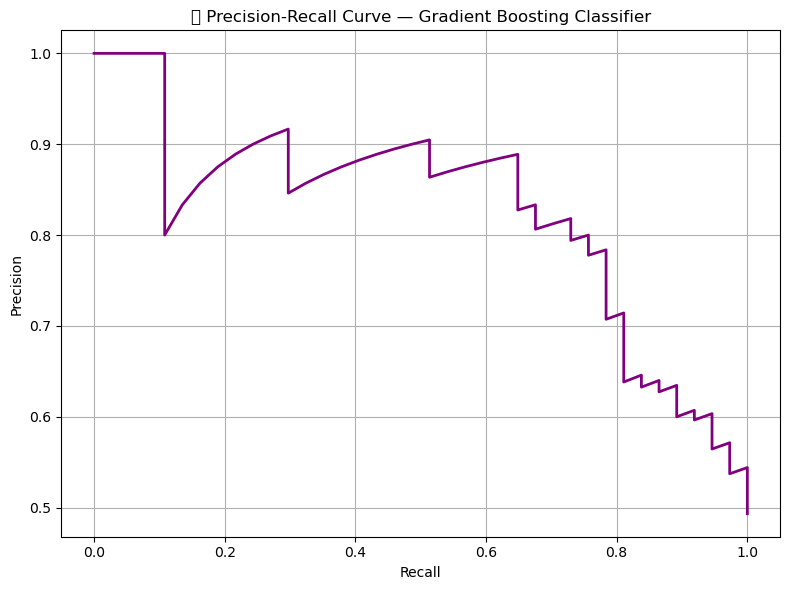

In [70]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('📊 Precision-Recall Curve — Gradient Boosting Classifier')
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
import seaborn as sns

In [22]:
X = load_dataset_risk_augmented[['Left Stock', 'Safety Stock', 'Purchasing', 'Usage (months)']]
y = load_dataset_risk_augmented['Stock_Risk_Flag']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [25]:
feature_importances = gb_classifier.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

C:\Users\User\AppData\Local\Temp\ipykernel_51340\2151018040.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


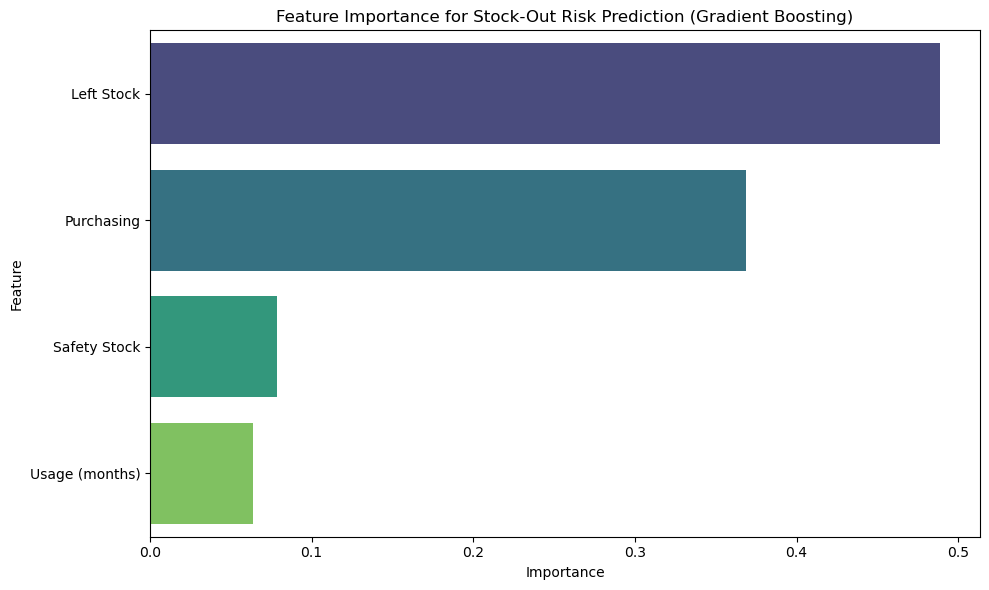

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance for Stock-Out Risk Prediction (Gradient Boosting)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [71]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold

In [73]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [74]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=gb,              # your trained Gradient Boosting model
    X=X_train_scaled,
    y=y_train,
    cv=cv,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

In [75]:
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_51340\1044115759.py:13: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\Downloads\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


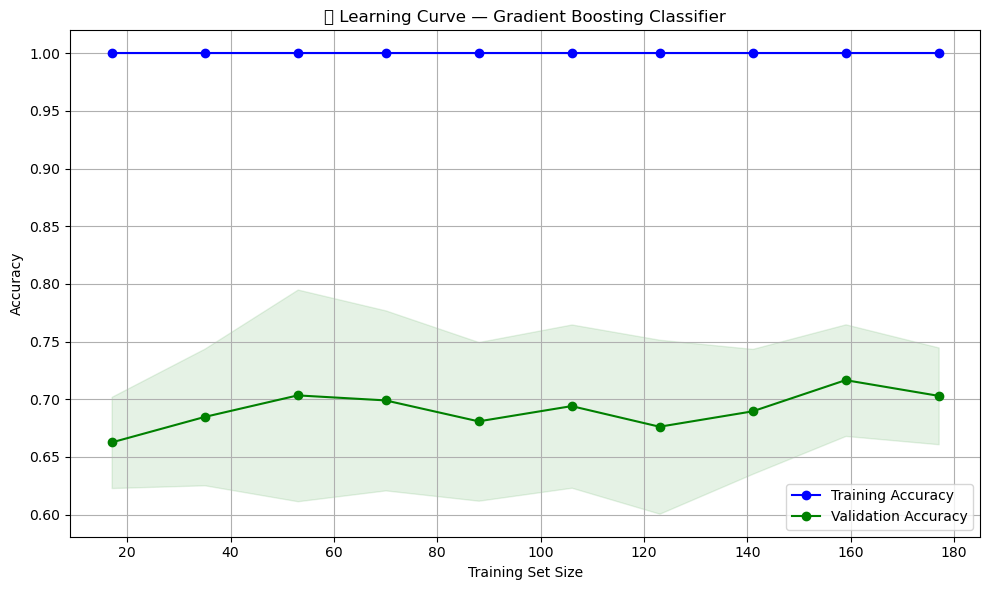

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

plt.title('📚 Learning Curve — Gradient Boosting Classifier')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [99]:
from sklearn.ensemble import RandomForestClassifier

In [100]:
target_col = 'expiry_loss_flag'
drop_cols = [target_col, 'Opportunity lost from expired drugs', 'Drug_Name_Label', 'Category_Expired']

In [101]:
X = load_dataset.drop(columns=drop_cols, errors='ignore').select_dtypes(include=[np.number]).dropna()
y = load_dataset.loc[X.index, target_col]

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [103]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [104]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [105]:
y_pred = clf.predict(X_test_scaled)

In [137]:
expiry_classification_df = X_test.copy()
expiry_classification_df["Predicted"] = clf.predict(X_test_scaled)
expiry_classification_df["Expiry Risk"] = expiry_classification_df["Predicted"].map({1: "Yes", 0: "No"})

expiry_classification_df.to_csv("expiry_predictions_classification.csv", index=False)
print("✅ expiry_predictions_classification.csv saved.")

✅ expiry_predictions_classification.csv saved.


In [138]:
# Step 1: Reuse cleaned numeric input features
X_full_expiry = X.copy()  # Same features you trained with
X_full_expiry_scaled = scaler.transform(X_full_expiry)

# Step 2: Create output DataFrame
expiry_classification_df = X_full_expiry.copy()
expiry_classification_df["Predicted"] = clf.predict(X_full_expiry_scaled)
expiry_classification_df["Expiry Risk"] = expiry_classification_df["Predicted"].map({1: "Yes", 0: "No"})

# Step 3: Export to CSV
expiry_classification_df.to_csv("expiry_predictions_classification_full.csv", index=False)
print("✅ expiry_predictions_classification_full.csv saved.")

✅ expiry_predictions_classification_full.csv saved.


In [106]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

In [107]:
print("\n📊 Classification Report — Predicting Expiry Risk (expiry_loss_flag):")
print(classification_report(y_test, y_pred, digits=4))

print("\n📊 Random Forest Model Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


📊 Classification Report — Predicting Expiry Risk (expiry_loss_flag):
              precision    recall  f1-score   support

           0     0.8095    0.8947    0.8500        38
           1     0.8788    0.7838    0.8286        37

    accuracy                         0.8400        75
   macro avg     0.8442    0.8393    0.8393        75
weighted avg     0.8437    0.8400    0.8394        75


📊 Random Forest Model Performance:
Accuracy: 0.84
Precision: 0.88
Recall: 0.78
Confusion Matrix:
[[34  4]
 [ 8 29]]


In [108]:
conf_matrix = confusion_matrix(y_test, y_pred)

C:\Users\User\AppData\Local\Temp\ipykernel_51340\1328217836.py:8: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\Downloads\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


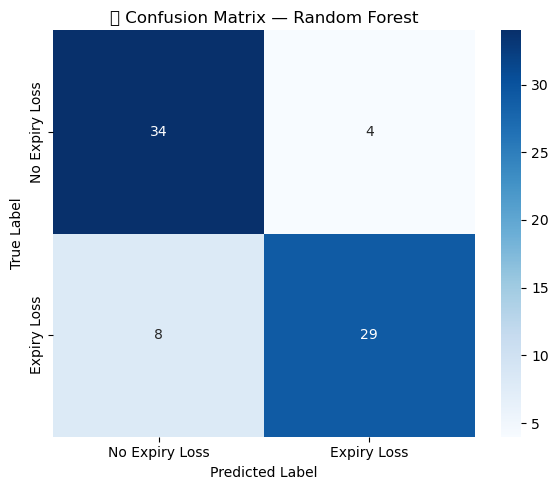

In [131]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Expiry Loss', 'Expiry Loss'], 
            yticklabels=['No Expiry Loss', 'Expiry Loss'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('📉 Confusion Matrix — Random Forest')
plt.tight_layout()
plt.show()

In [110]:
from sklearn.metrics import roc_curve, auc

In [111]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [112]:
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

C:\Users\User\AppData\Local\Temp\ipykernel_51340\844375137.py:9: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\Downloads\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


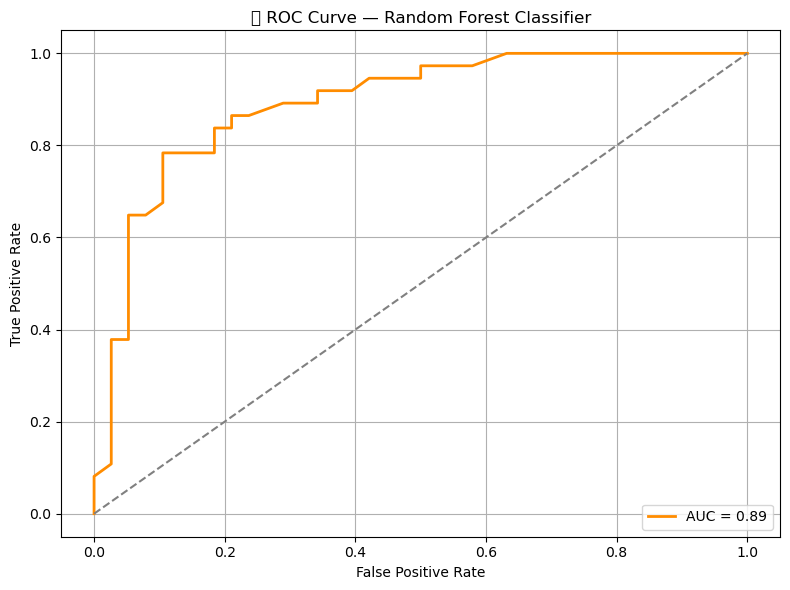

In [130]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 ROC Curve — Random Forest Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [115]:
from sklearn.metrics import precision_recall_curve

In [116]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [117]:
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba)

C:\Users\User\AppData\Local\Temp\ipykernel_51340\974841601.py:7: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\Downloads\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


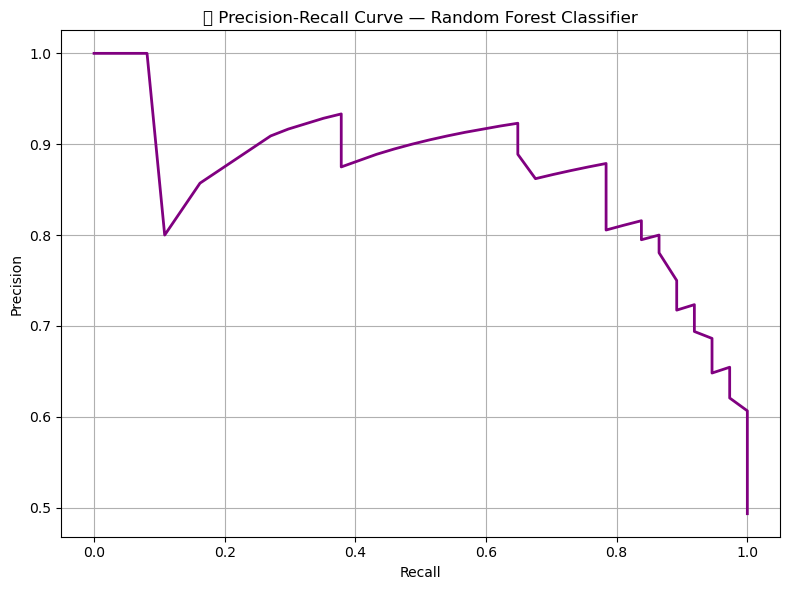

In [129]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('📊 Precision-Recall Curve — Random Forest Classifier')
plt.grid(True)
plt.tight_layout()
plt.show()

In [119]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

C:\Users\User\AppData\Local\Temp\ipykernel_51340\870646945.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances.head(15), x='Importance', y='Feature', palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_51340\870646945.py:6: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\Downloads\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


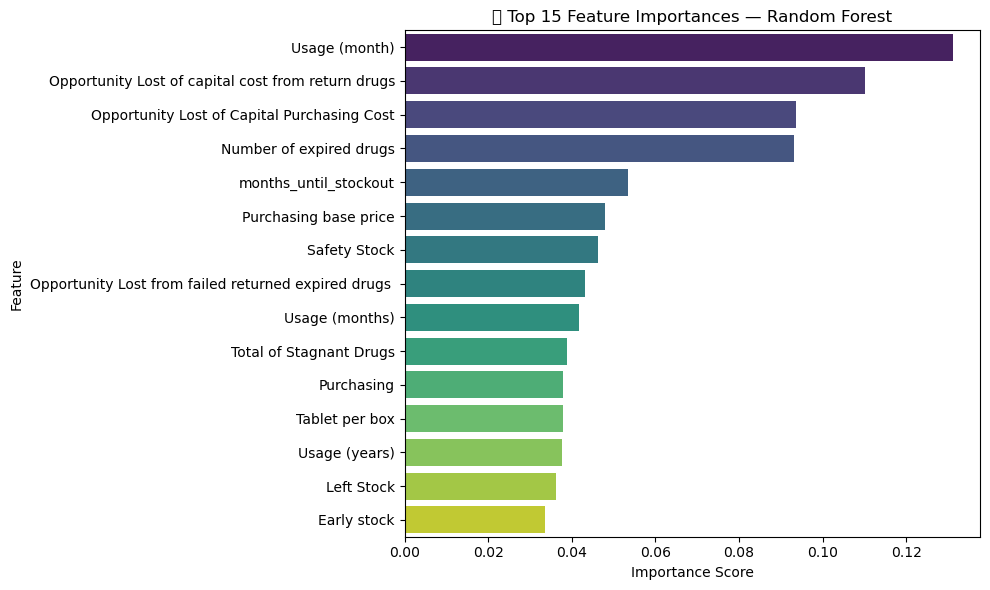

In [128]:
plt.figure(figsize=(10, 6))
sns.barplot(data=importances.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('🔥 Top 15 Feature Importances — Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [121]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold

In [122]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [123]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [124]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=clf,              # your trained Gradient Boosting model
    X=X_train_scaled,
    y=y_train,
    cv=cv,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

In [125]:
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_51340\1900974884.py:13: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


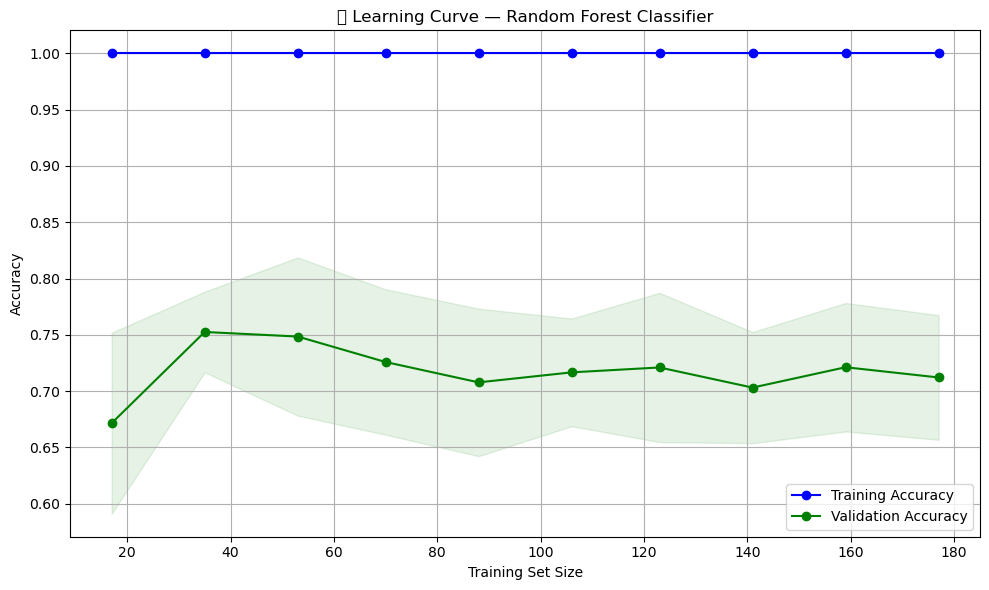

In [127]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

plt.title('📚 Learning Curve — Random Forest Classifier')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [40]:
regression_target = 'Opportunity lost from expired drugs'
regression_drop_cols = [regression_target, 'expiry_loss_flag', 'Drug_Name_Label', 'Category_Expired']

In [41]:
X_reg = load_dataset.drop(columns=regression_drop_cols, errors='ignore').select_dtypes(include=[np.number]).dropna()
y_reg = load_dataset.loc[X_reg.index, regression_target]

In [42]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, random_state=42)

In [43]:
scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

In [44]:
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train_reg_scaled, y_train_reg)

RandomForestRegressor(random_state=42)

In [45]:
y_pred_reg = reg.predict(X_test_reg_scaled)

In [139]:
expiry_regression_df = X_test_reg.copy()
expiry_regression_df["Predicted Loss"] = y_pred_reg
expiry_regression_df["Expiry Risk"] = expiry_regression_df["Predicted Loss"].apply(lambda x: "Yes" if x > 0 else "No")

expiry_regression_df.to_csv("expiry_predictions_regression.csv", index=False)
print("✅ expiry_predictions_regression.csv saved.")

✅ expiry_predictions_regression.csv saved.


In [140]:
X_full_reg = X_reg.copy()
X_full_reg_scaled = scaler.transform(X_full_reg)

expiry_regression_df = X_full_reg.copy()
expiry_regression_df["Predicted Loss"] = reg.predict(X_full_reg_scaled)
expiry_regression_df["Expiry Risk"] = expiry_regression_df["Predicted Loss"].apply(lambda x: "Yes" if x > 0 else "No")

expiry_regression_df.to_csv("expiry_predictions_regression_full.csv", index=False)
print("✅ expiry_predictions_regression_full.csv saved.")

✅ expiry_predictions_regression_full.csv saved.


In [46]:
mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

print("\n📈 Regression Report — Predicting Loss Amount (Opportunity lost from expired drugs):")
print(f"MAE      : {mae:.4f}")
print(f"MSE      : {mse:.4f}")
print(f"RMSE     : {rmse:.4f}")
print(f"R2 Score : {r2:.4f}")


📈 Regression Report — Predicting Loss Amount (Opportunity lost from expired drugs):
MAE      : 0.0109
MSE      : 0.0039
RMSE     : 0.0627
R2 Score : 0.8494


C:\Users\User\AppData\Local\Temp\ipykernel_51340\1982440569.py:11: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\Downloads\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


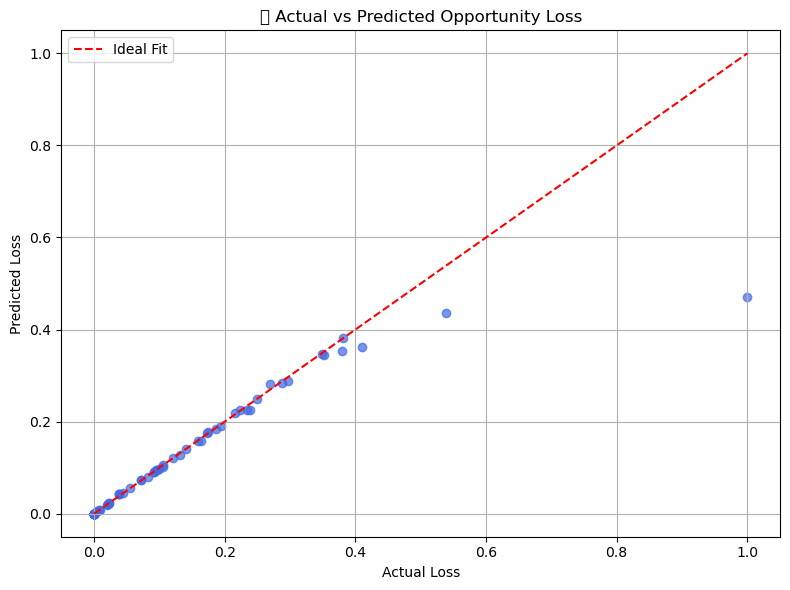

In [47]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.7, color='royalblue')
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()],
         'r--', label="Ideal Fit")
plt.xlabel("Actual Loss")
plt.ylabel("Predicted Loss")
plt.title("📉 Actual vs Predicted Opportunity Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_51340\1977973370.py:9: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


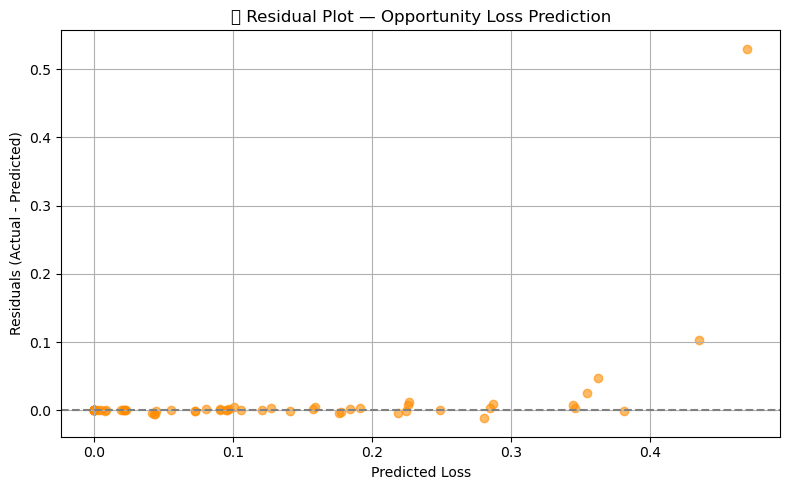

In [48]:
residuals = y_test_reg - y_pred_reg
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_reg, residuals, alpha=0.6, color='darkorange')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted Loss")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("📉 Residual Plot — Opportunity Loss Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()

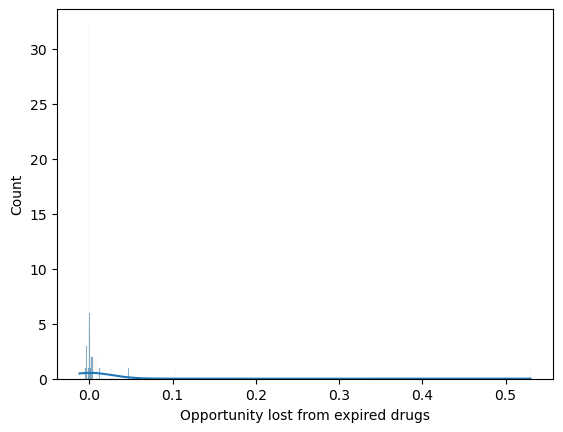

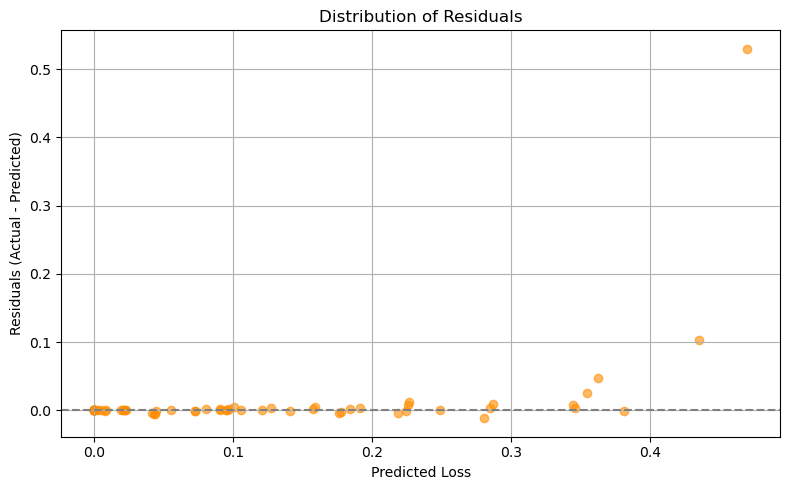

In [91]:
sns.histplot(residuals, kde=True)
residuals = y_test_reg - y_pred_reg
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_reg, residuals, alpha=0.6, color='darkorange')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted Loss")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Distribution of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

In [141]:
features_reg = X_reg.copy()    
features_class = X.copy()     

features_reg_scaled = scaler.transform(features_reg)
features_class_scaled = scaler.transform(features_class)


predicted_loss = reg.predict(features_reg_scaled)
predicted_flag = clf.predict(features_class_scaled)


expiry_df = load_dataset.loc[features_reg.index].copy()


expiry_df["Actual Expiry Flag"] = expiry_df["expiry_loss_flag"]
expiry_df["Actual Expiry Loss"] = expiry_df["Opportunity lost from expired drugs"]


expiry_df["Predicted Loss"] = predicted_loss
expiry_df["Predicted Expiry Flag"] = predicted_flag
expiry_df["Expiry Risk"] = expiry_df["Predicted Expiry Flag"].map({1: "Yes", 0: "No"})


expiry_df.to_csv("expiry_predictions.csv", index=False)
print("✅ expiry_predictions.csv saved with actuals and predictions.")

✅ expiry_predictions.csv saved with actuals and predictions.
